In [13]:
# General Libraries
import numpy as np
import pandas as pd
import os

# True Model
from scipy.integrate import odeint
from scipy.fft import fft

# Machine Learning Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.utils import Sequence
from tensorflow import keras


# Data Preprocessing
from sklearn.preprocessing import StandardScaler


# Plotting Libraries
import matplotlib.pylab as plt
import seaborn as sns


# My Modules
from wilkeXAI.data_generator import DataGenerator
import wilkeXAI.wilke_shap as fwg
  
# Set Seaborn Theme
sns.set_theme(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=1, color_codes=True, rc=None)


In [3]:
suffix = "delta_1_gamma_0"

anal_indiv = pd.read_csv("Results/analytic/individual/"+suffix+".csv")
anal_agg = pd.read_csv("Results/analytic/aggregate/"+suffix+".csv")

shap_indiv = pd.read_csv("Results/shap/individual/"+suffix+".csv")
shap_agg = pd.read_csv("Results/shap/aggregate/"+suffix+".csv")

lime_indiv = pd.read_csv("Results/lime/individual/"+suffix+".csv")
lime_agg = pd.read_csv("Results/lime/aggregate/"+suffix+".csv")

In [7]:
data_parameters = {'alpha' : [-1],'beta' : [1], 'gamma' :[0.37], 'delta' : [2], 'omega' : [1.2]}
generator = DataGenerator()

X_train, y_train = generator.generate(num_samples=int(1e1), params = data_parameters)
X_test, y_test = generator.generate(num_samples=int(1e1), params = data_parameters)

Generating Data…: 100%|████████████████████| 10/10 [00:00<00:00, 73.34it/s]


In [8]:
models = {'ml': "ml_model", 
         'true': "true_model"}

In [40]:
lime_indiv = lime_indiv.set_index(['num','feature', 'contribution', 'model'])

anal_indiv = anal_indiv.set_index(['num','feature', 'contribution', 'model'])

shap_indiv = shap_indiv.set_index(['num','feature', 'contribution', 'model'])

In [26]:
def agg_plot(agg_vals, test_labels, explainer_type='shap', models=models):
    """
        Plotting routine to visualise the aggregated feature importance.
    """
    f, axs = plt.subplots(len(models), test_labels.shape[1], 
                          figsize=(6*test_labels.shape[1], 4*len(models)), 
                          gridspec_kw=dict(width_ratios=4*np.ones((test_labels.shape[1]))))

    for i, __model in enumerate(models):
        for j, __contribution in enumerate(test_labels):
            sns.barplot(data = agg_vals.xs((__contribution, __model), level=('contribution', 'model')),
                x = agg_vals.xs((__contribution, __model), level=('contribution', 'model')).index,
                y = 'contrib', label = __model, ax=axs[i,j])
            axs[i,j].set_title(r"Aggregate Feature Contribution to "+__contribution+" in the "+__model+" Model")
            axs[i,j].set_ylabel('Feature Contribution [ ]')

    f.tight_layout()
    f.savefig("Images/"+explainer_type+"_aggregated"+suffix+".svg", dpi='figure')

In [33]:
anal_agg = anal_agg.set_index(['feature', 'contribution', 'model'])

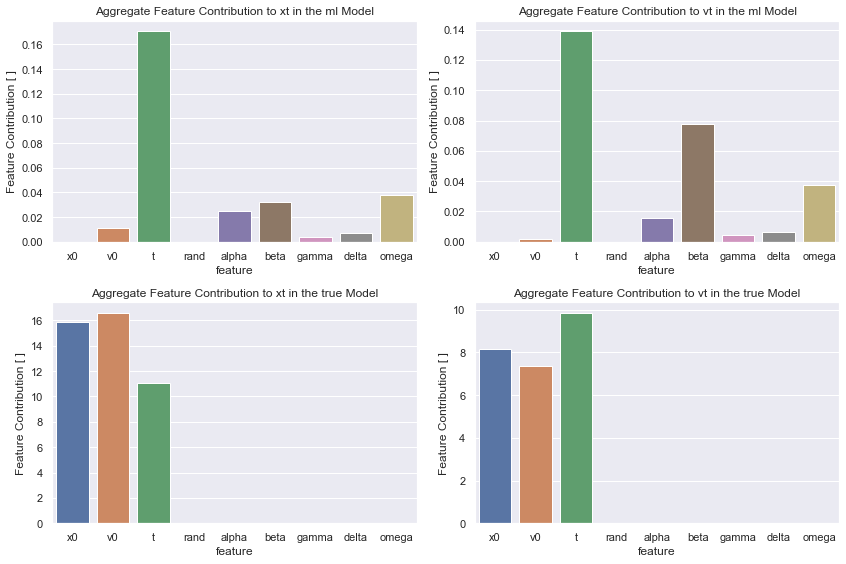

In [34]:
agg_plot(anal_agg, y_test, explainer_type='analytic')

In [43]:
def exp_plot(feature_attributions, test_labels, test_data, models=models, explainer_type='shap'):
    """
        Plotting routine to visualise the explainers' results. Plots individual
        feature contribution for each model and each feature.
    """
    f, axs = plt.subplots(test_labels.shape[1], test_data.shape[1], 
                          figsize=(4*test_data.shape[1], 8), 
                          gridspec_kw=dict(width_ratios=4*np.ones((test_data.shape[1]))))

    for i, __feature in enumerate(test_data.columns):
        for j, __contribution in enumerate(test_labels.columns):
            for __model in models:
                sns.scatterplot(data = feature_attributions.xs((__feature, __contribution, __model), 
                                                  level=('feature', 'contribution', 'model')), 
                                x = feature_attributions.xs((__feature, __contribution, 'true'), 
                                               level=('feature', 'contribution', 'model')).index,
                                y = feature_attributions.xs((__feature, __contribution, __model), 
                                             level=('feature', 'contribution', 'model'))[__feature],
                                label = __model, ax=axs[j,i])  

            axs[j,i].set_title(r"Feature Contribution of "+__feature+" to "+__contribution+"")
            axs[j,i].set_xlabel('Index [ ]')
            axs[j,i].set_ylabel('Feature Contribution [ ]')

    f.tight_layout()

    f.savefig("Images/"+explainer_type+"_summary"+suffix+"_kernel_good.svg", dpi='figure')

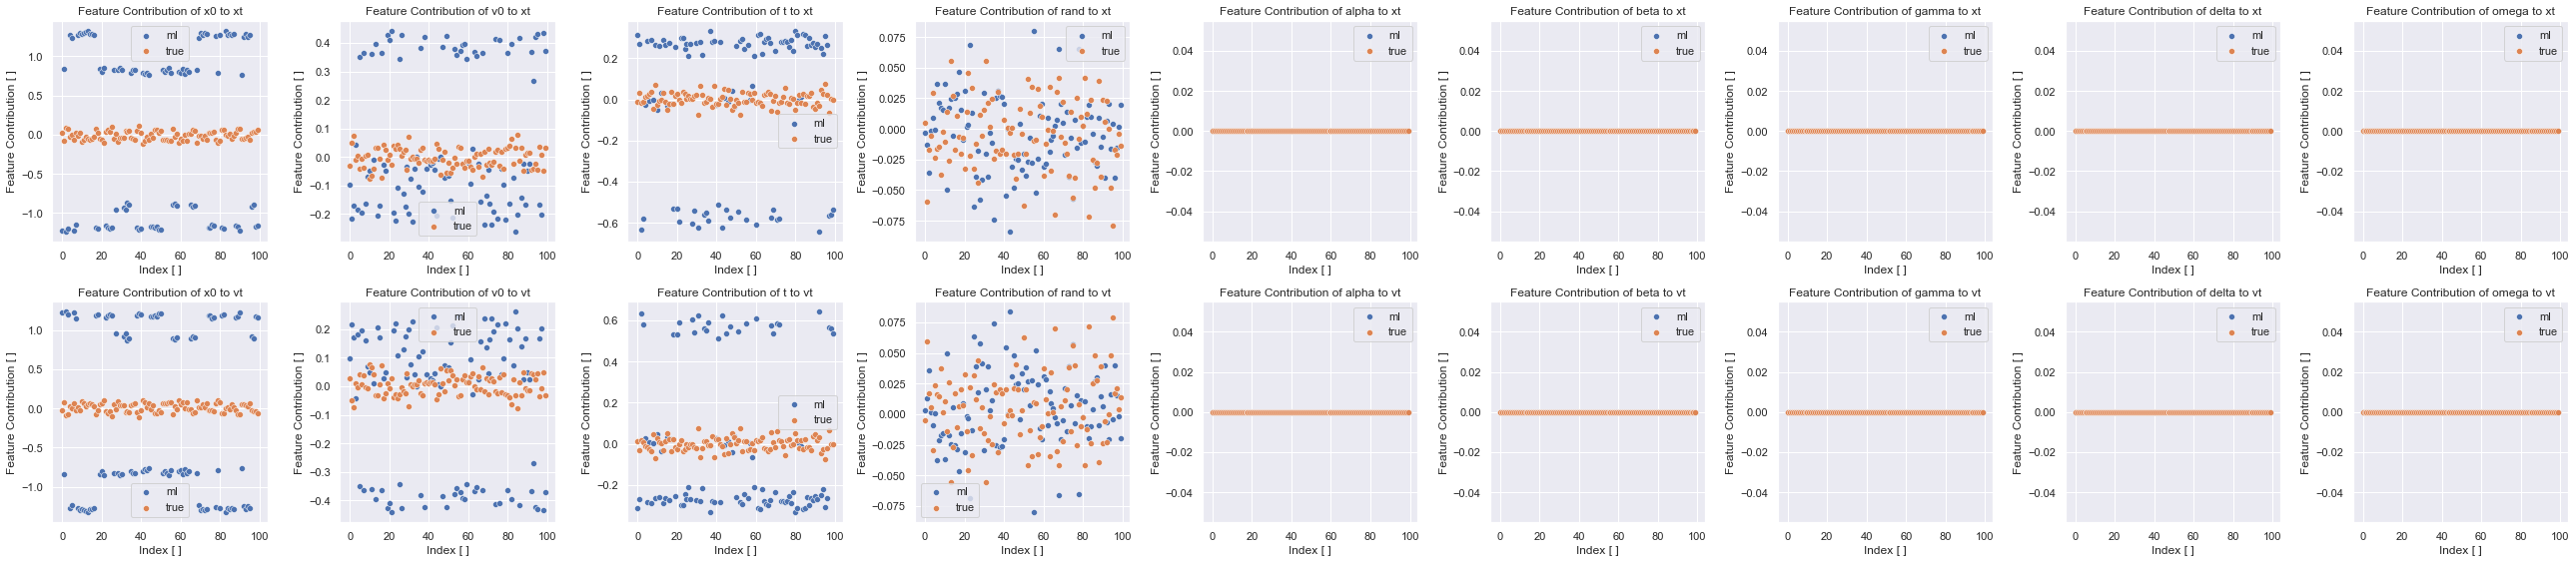

In [45]:
exp_plot(lime_indiv, y_test, X_test, models=models, explainer_type='lime')

In [2]:
"""
Define and Machine Learning Model
"""

def MLModel():
    opt = Adam(learning_rate=0.001, beta_1=0.7)
    loss='mse'
    model = Sequential([
        layers.Flatten(),
        layers.Dense(200, activation='relu'),
        layers.Dense(200, activation='relu'),
        layers.Dense(200, activation='relu'),
        layers.Dense(200, activation='relu'),
        layers.Dense(200, activation='relu'),
        layers.Dense(200, activation='relu'),
        layers.Dense(200, activation='relu'),
        layers.Dense(200, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(32, activation='relu'),
        layers.Dense(32, activation='sigmoid'),
        layers.Dense(32, activation='tanh'),
        layers.Dense(2)            
    ])
    model.compile(optimizer=opt, loss=loss)
    return model


In [35]:
suffix = "Run_1"
generator = DataGenerator()
# Generate the data
X_train, y_train = generator.generate(num_samples=int(1e4))
X_test, y_test = generator.generate(num_samples=int(1e3))

Generating Data…: 100%|████████████████| 1000/1000 [00:14<00:00, 67.49it/s]


In [48]:
X_train.loc[:,'x0':'t']

,x0,v0,t
0,-1.015976,0.701215,0.0
1,-1.015976,0.701215,0.2
2,-1.015976,0.701215,0.4
3,-1.015976,0.701215,0.6
4,-1.015976,0.701215,0.8
...,...,...,...
4999995,0.437671,0.225635,99.0
4999996,0.437671,0.225635,99.2
4999997,0.437671,0.225635,99.4
4999998,0.437671,0.225635,99.6


In [50]:
scaler = StandardScaler()

scaler.fit(X_train.loc[:,'x0':'t'].values)
scaler.transform(X_train.loc[:,'x0':'t'].values, copy=False)
scaler.transform(X_test.loc[:,'x0':'t'].values, copy = False)

array([[-0.32969714,  0.21075447, -1.72859016],
       [-0.32969714,  0.21075447, -1.72166195],
       [-0.32969714,  0.21075447, -1.71473373],
       ...,
       [ 1.07581826, -0.90680433,  1.71473373],
       [ 1.07581826, -0.90680433,  1.72166195],
       [ 1.07581826, -0.90680433,  1.72859016]])

In [73]:
X_test.iloc[:,:3]

,x0,v0,t
0,-0.329697,0.210754,-1.728590
1,-0.329697,0.210754,-1.721662
2,-0.329697,0.210754,-1.714734
3,-0.329697,0.210754,-1.707806
4,-0.329697,0.210754,-1.700877
...,...,...,...
499995,1.075818,-0.906804,1.700877
499996,1.075818,-0.906804,1.707806
499997,1.075818,-0.906804,1.714734
499998,1.075818,-0.906804,1.721662


In [72]:
if type(X_test.values) == np.ndarray:
    print('bleh')

bleh


In [51]:
model = MLModel()
true_model = fwg.TrueModel(scaler, X_test)

In [52]:
# Train Network
# Model Weights Path
checkpoint_path = "Networks//training//"+suffix+"cp1.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_dir,
                                                 save_weights_only=True,
                                                 verbose=1)
callbacks = [cp_callback,
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15),
             tf.keras.callbacks.EarlyStopping(monitor='loss', patience=15)]


history=model.fit(X_train, y_train, steps_per_epoch=None, epochs=3, 
                  validation_split=0.2, batch_size=20364, shuffle=True, callbacks=callbacks, verbose=2)

Epoch 1/3
197/197 - 25s - loss: 0.0895 - val_loss: 0.0678

Epoch 00001: saving model to Networks\training
Epoch 2/3
197/197 - 25s - loss: 0.0688 - val_loss: 0.0681

Epoch 00002: saving model to Networks\training
Epoch 3/3
197/197 - 24s - loss: 0.0677 - val_loss: 0.0662

Epoch 00003: saving model to Networks\training


In [57]:
X_test.columns[:4]

Index(['x0', 'v0', 't', 'rand'], dtype='object')

In [8]:
models = {'ml': model, 
         'true': true_model}
       
for exp_type in ['shap', 'lime', 'analytic']:
    explainer_curr = fwg.wilke_explainer(models, X_train, X_test, y_test, explainer_type=exp_type, tolerance = 1)
    explainer_curr.eval_explainer().to_csv("Results/"+exp_type+"/individual/"+suffix+".csv")
    explainer_curr.aggregate().to_csv("Results/"+exp_type+"/aggregate/"+suffix+".csv")

0it [00:00, ?it/s]

IndexError: list index out of range

In [16]:
explainer_test = fwg.wilke_explainer(models, X_train, X_test, y_test, explainer_type='shap', tolerance = 0.1)

In [26]:
choose_vals(0,9)

array([ True,  True,  True, ...,  True,  True,  True])

In [25]:
def choose_vals(i, num_features):
        """
            Chooses the data points on which the explainer will be evaluated for
            a given feature. First, removes any points where the prediction is
            further than tolerance from the true value. Second, takes values in
            a band of thickness tol around 0 for all features not currently being
            evaluated on. Third, chooses a random subset of length num_vals of 
            these values. This function should never be called outside of this class.
            
            Parameters
            ----------
            i : int, index of the feature being explained
            feature : str, the feature being explained
            num_features : the total number of features
            
            Returns
            ----------
            data_arr : pandas.DataFrame, array of the chosen values.
        """
        vals = np.abs(np.linalg.norm((models['ml']).predict(X_test), axis=1) - 
                      np.linalg.norm(y_test, axis=1))
        data_arr = X_test.iloc[np.where(vals < 0.1)]
        where__ = np.ones_like(data_arr.values[:,i], dtype=bool)
        for j in range(1,num_features):
            where__ = np.multiply(where__, np.abs(data_arr.values[:,(i + j)%num_features])<self.tol)
        return where__
    

In [ ]:
def choose_data(i, num_features):
        """
            Chooses the data points on which the explainer will be evaluated for
            a given feature. First, removes any points where the prediction is
            further than tolerance from the true value. Second, takes values in
            a band of thickness tol around 0 for all features not currently being
            evaluated on. Third, chooses a random subset of length num_vals of 
            these values. This function should never be called outside of this class.
            
            Parameters
            ----------
            i : int, index of the feature being explained
            feature : str, the feature being explained
            num_features : the total number of features
            
            Returns
            ----------
            data_arr : pandas.DataFrame, array of the chosen values.
        """
        vals = np.abs(np.linalg.norm((models['ml']).predict(X_test), axis=1) - 
                      np.linalg.norm(y_test, axis=1))
        
        print(vals)
        data_arr = self.test_data.iloc[np.where(vals < self.tolerance)]
        where__ = np.ones_like(data_arr.values[:,i], dtype=bool)
        for j in range(1,num_features):
            where__ = np.multiply(where__, np.abs(data_arr.values[:,(i + j)%num_features])<self.tol)
        data_arr = data_arr.iloc[where__]
        data_arr = data_arr.iloc[np.sort(
            np.random.choice(data_arr.shape[0], np.min([self.num_vals, data_arr.shape[0]]), replace=False))]
        return data_arr

In [24]:
where__ = np.ones_like(data_arr.values[:,i], dtype=bool)

NameError: name 'data_arr' is not defined

In [11]:
params = {'alpha' : [-1],'beta' : [1], 'gamma' :[0.37], 'delta' : [1], 'omega' : [1.2]}

In [15]:
for beta in params['gamma']:
    print(beta)

0.37


In [34]:
X_test.set_index(['alpha', 'beta', 'gamma', 'delta', 'omega'])

AttributeError: 'numpy.ndarray' object has no attribute 'set_index'

In [32]:
X_test = scaler.inverse_transform(X_test)

In [33]:
X_test

array([[-1.95477679, -0.70577194,  0.        , ...,  0.37      ,
         1.        ,  1.2       ],
       [-1.95477679, -0.70577194,  0.2       , ...,  0.37      ,
         1.        ,  1.2       ],
       [-1.95477679, -0.70577194,  0.4       , ...,  0.37      ,
         1.        ,  1.2       ],
       ...,
       [ 0.12764016,  0.75095404, 99.4       , ...,  0.37      ,
         1.        ,  1.2       ],
       [ 0.12764016,  0.75095404, 99.6       , ...,  0.37      ,
         1.        ,  1.2       ],
       [ 0.12764016,  0.75095404, 99.8       , ...,  0.37      ,
         1.        ,  1.2       ]])